**PUBG Win Placement Prediction**

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train_V2.csv', 'sample_submission_V2.csv', 'test_V2.csv']


> The motivation for this competition is:
1. PUBG is the only game I play
2. I want to expand my Machine Learning and Data Science skills to other fields


In [0]:
#Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

> The **Features** in this dataset are shown below. Some of them are assists, boosts, kills, matchDuration etc..
The **Target** in this dataset is winPlacePercentage which is the probability of players winning a game.

In [0]:
#Read dataset and remove NA values
dataset = pd.read_csv("../input/train_V2.csv")
dataset.dropna(inplace = True)
dataset.isnull().any().any()
dataset.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


> I'm extracting the necessary features in the code below and converting them to a dataframe. I do the same to the targets as well. Note that I have removed all the NAs in the code above. 

In [0]:
#This is the dataframe
X = dataset.iloc[:, [3,4,5,6,7,8,9,10,11,12,13,16,17,18,19,20,21,22,23,24,26,27]]
y = dataset.iloc[:, 28]


> Please note that features such as 'matchDuration' and 'walkDistance' are excluded from the dataframe. That is because the longer the match duration the higher the chance of winning a game. Same goes for walk distance--players are supposed to walk more(due to the circle closing in) as they progress in the game. The use of these two variables in my analysis resulted in an overfitting of the data which i was not happy with. The scores of different algorithms with these two variables were close to 97%. 

> As a good data scientist, I am going to split my dataset into a training and test set to avoid overfitting :)

In [0]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size = 0.3, random_state = 0)

> Feature scaling or standardization(z-scores). Standardization means rescaling the features such that they have the properties of a standard normal distribution with a mean of zero and a standard deviation of one. This is important because we want the variance of the features in the same range.

In [0]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
scaled = StandardScaler()
X_train_1 = scaled.fit_transform(X_train_1)
X_test_1 = scaled.transform(X_test_1)


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


> I'm starting off my quest to find the best algorithms with Random Forest regression. The decision to chose a regression algorithm instead of a classification algorithm is due to the fact that the predictions are probabilities ranging from 0 to 1. If my targets were either 0 or 1 I would've chosen a classification algorithm for this dataset.
> > In summary, Random forest is a technique which uses multiple decision trees and bootstrap aggregation. The bootstrap aggregation involves training each decision tree on a different data sample where sampling is done with replacement. Instead of using one decison tree to find an output, multiple decision trees are combined in determining the final output. More on Random forest can be found here: https://medium.com/datadriveninvestor/random-forest-regression-9871bc9a25eb

In [0]:
#Trying Random Forest to get the most important features
from sklearn.ensemble import RandomForestRegressor
rforest = RandomForestRegressor(n_estimators= 10, max_depth = 5)
rforest.fit(X_train_1,y_train_1)
print("Random Forest Score: ", rforest.score(X_test_1,y_test_1))

Random Forest Score:  0.7553168819920004


> 75% is a pretty decent score.

> Here I am calculating the MSE which is the Mean Squared Error. MSE measures the average of the squares of the errors—that is the average squared difference between the estimated values and what is estimated. 

In [0]:
#mean Squared error
from sklearn.metrics import mean_squared_error
y_pred_rf = rforest.predict(X_test_1)
mse_rf = mean_squared_error(y_test_1, y_pred_rf)
print("Random forest MSE: ", mse_rf)

Random forest MSE:  0.02311611562425801


> In the code below I'm extarcting the most important features. The bar plot will determine the important factors on a scale of 0 to 1

In [0]:
#Extract Feature Names
feature_names = list(X)
feature_names = np.array(feature_names)
feature_names

array(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills',
       'heals', 'killPlace', 'killPoints', 'kills', 'killStreaks',
       'longestKill', 'maxPlace', 'numGroups', 'rankPoints', 'revives',
       'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'weaponsAcquired', 'winPoints'], dtype='<U15')

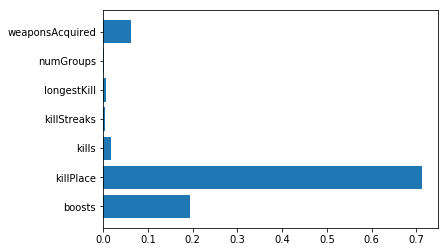

In [0]:
#Plot the most important features
important_inds = (rforest.feature_importances_ > 0)
importance_names = feature_names[important_inds]
importance_vals = rforest.feature_importances_[important_inds]
plt.barh(range(len(importance_vals)), importance_vals);
plt.yticks(np.arange(len(importance_vals)), importance_names);


> As observed in the plot above, the most important features are killPlace, Boosts, and weapons acquired. 

> Now lets try Decision trees. 

In [0]:
#Decison Tree
from sklearn.tree import DecisionTreeRegressor

DT = DecisionTreeRegressor(max_depth=2)
DT.fit(X_train_1,y_train_1)
DT.score(X_test_1,y_test_1)


0.6332286504443305

> The decision tree score is decent but not better than random forest algorithm. 

> Checking the most important features int he code below

In [0]:
feature_names = list(X)
feature_names = np.array(feature_names)
feature_names


array(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills',
       'heals', 'killPlace', 'killPoints', 'kills', 'killStreaks',
       'longestKill', 'maxPlace', 'numGroups', 'rankPoints', 'revives',
       'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'weaponsAcquired', 'winPoints'], dtype='<U15')

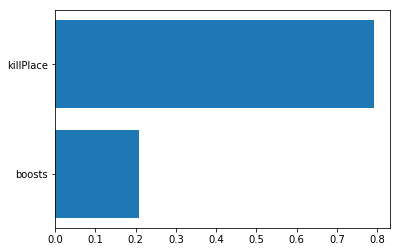

In [0]:
important_inds = (DT.feature_importances_ > 0)
importance_names = feature_names[important_inds]
importance_vals = DT.feature_importances_[important_inds]
plt.barh(range(len(importance_vals)), importance_vals);
plt.yticks(np.arange(len(importance_vals)), importance_names);

> As observed above the only two important features for a decision tree are killPlace and boosts. Note that when I used Random Forest, I got to know that there is another important feature (i.e. weaponsAcquired) than the above two. I am going to stick with random forest because its a collection of decision trees whose results are aggregated. Random Forest limits overfitting whithout increasing error due to bias and reduce variance by training on different samples of data.

> I'm only selecting the important features obtained from Random Forest to run more algorithms

In [0]:
#Now, only selecting the 3 most important features which are 'weaponsAcquired', 'killPlace' and 'boosts'
X = dataset.iloc[:, [4,9,26]]
y = dataset.iloc[:, 28]


> Repeating the split

In [0]:
# Splitting the dataset into the Training set and Test set again
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

> Repeating feature scaling on the new test and train set

In [0]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
scaled = StandardScaler()
X_train = scaled.fit_transform(X_train)
X_test = scaled.transform(X_test)


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  """


> Running Random Forest on the Test set that has been given in this competition

In [0]:
#Random Forest on 3 features again to make predicitons on our test set(given)

from sklearn.ensemble import RandomForestRegressor
randomforest = RandomForestRegressor(n_estimators= 10, max_depth = 5)
randomforest.fit(X_train,y_train)
print("Random Forest Score: ", randomforest.score(X_test,y_test))

Random Forest Score:  0.7392482646118183


> RF score close to what was predicted earlier

> Below: 
> >Reading Test set
> > > Making predictions on Test set
> > > > Putting the predictions in a submission file

In [0]:
#Test set
test = pd.read_csv("../input/test_V2.csv")
X_X = test[["boosts", "killPlace", "weaponsAcquired"]]
X_X.head()

,boosts,killPlace,weaponsAcquired
0,0,73,1
1,4,11,6
2,0,49,4
3,0,54,3
4,4,7,4


In [0]:
#Make preds on test set
test_rf = randomforest.predict(X_X)

In [0]:
#Making predictions on the result set
results = pd.read_csv("../input/sample_submission_V2.csv")
results.head()

,Id,winPlacePerc
0,9329eb41e215eb,1
1,639bd0dcd7bda8,1
2,63d5c8ef8dfe91,1
3,cf5b81422591d1,1
4,ee6a295187ba21,1


In [0]:
results["winPlacePerc"] = test_rf

In [0]:
#results.to_csv('submission.csv', index = False)

> Moving on to Linear Regression. Lets compare how Linear Regression does as compared to Random Forest

In [0]:
#Linear Regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
lr.score(X_train,y_train)

> A score of 0.64 is not as good as Random Forest but slightly better than Decision Trees. Although the score is satisfactory, I'll try another algorithm to obtain a better accuracy than 0.75

> Now, using Artificial Neural Networks on our dataset to make predicitons

In [0]:

# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [0]:
regressor = Sequential()

In [0]:
# Adding the input layer and the first hidden layer
regressor.add(Dense(units = 2, kernel_initializer = 'normal', activation = 'relu', input_dim = 3))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# Adding the second hidden layer
regressor.add(Dense(units = 2, kernel_initializer = 'normal', activation = 'relu'))

In [0]:
#Adding third hidden layer
regressor.add(Dense(units = 2, kernel_initializer = 'normal', activation = 'relu'))

> Using "Linear" activation function because this is a regression problem

In [0]:
# Adding the output layer
regressor.add(Dense(units = 1,  kernel_initializer = 'normal', activation = 'linear'))

> The loss function is mean squared error and metric as accuracy. The outputs from fitting our ANN will be MSE and model accuracy

In [0]:
# Compiling the ANN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [0]:
# Fitting the ANN to the Training set
regressor.fit(X_train, y_train, batch_size = 3, epochs = 5)

Epoch 1/5
   1908/3112875 [..............................] - ETA: 1:04:15 - loss: 0.0310 - acc: 0.0755

KeyboardInterrupt: 

After 5 epochs the loss and accuracy are as follows:
loss: 0.0303 - acc: 0.0761


---

The loss which is measured in MSE(Mean Squared Error) is close to the MSE I calculated through Random Forest algorithm. I think that the more time put into the ANN, the better chances of achieiving a better result. However, running 5 epochs ran overnight. I can only imagine how long 100 epochs would take.

So, in conclusion, the winner in this problem is Random Forest. By using multiple decision trees and sampling over different samples random forest is able to achieve the best accuracy for this problem. We can expect decision trees to achieve results closer to random forest as well. I also believe that it is possible to minimize the MSE using Artificial Neural Networks but that is time consuming. For now, I'm happy with my results.